In [18]:
using DataFrames, FileIO, DelimitedFiles
using Plots, Optim, LsqFit
using Chemfiles, HDF5, JUMD, LinearAlgebra, Statistics

In [19]:
# Get ready
dir_ctv_pca = string("/home/pbarletta/labo/20/reobp/run/ctv/pca/")
dir_rtdos = string("/home/pbarletta/labo/20/reobp/rtdos_log")

aa = 113
nstlim = 12000
phs = collect(2.0:.5:7.5)
idx = collect(1:12)

titrable_resis = [4, 5, 11, 13, 20, 24, 30, 33, 37, 39, 40,
    48, 58, 73, 77, 78, 87, 93, 94, 97, 117]
titrable_resnames = ["GL4", "GL4", "HIP", "GL4", "GL4", "AS4",
    "AS4", "GL4", "AS4", "GL4", "AS4", "GL4", "AS4", "GL4", "AS4",
    "GL4", "AS4", "GL4", "GL4", "HIP", "AS4"]
titrable_cnt = length(titrable_resis)

21

In [20]:
function diff_trj_avg(in_avg_filename::AbstractString, in_trj_filename::AbstractString,
        mask::Array{Int64, 1})
    in_avg_trj = Trajectory(in_avg_filename)
    in_avg_frm = read(in_avg_trj)
    in_avg_top = Topology(in_avg_frm)
    orig_aa = convert(Int64, count_residues(in_avg_top))

    # Get indices de CA
    orig_cas_idx = Array{Int64, 1}(undef, orig_aa)
    k = 0
    for i = 0:convert(Int64, size(in_avg_top)-1)
        if Chemfiles.name(Atom(in_avg_frm, i)) == "CA"
            k+=1
            orig_cas_idx[k] = i + 1
        end
    end
    cas_idx = orig_cas_idx[mask]
    aa = length(cas_idx)
    aa_3 = aa * 3
    # Estas son las coordenadas q voy a usar p/ restar
    avg_xyz = positions(in_avg_frm)[:, cas_idx];

    # Preparo
    in_trj = Trajectory(in_trj_filename)
    nframes = convert(Int64, length(in_trj))
    close(in_trj)
    diff_pdb = Array{Float64, 2}(undef, aa_3, nframes)
    vec_nframes = convert(Array{Int64}, collect(0:nframes/10:nframes));

    # Ahora obtengo las proyecciones
    for j = 1:length(vec_nframes)-1
        in_trj = Trajectory(in_trj_filename)
        for i = vec_nframes[j]:vec_nframes[j+1]-1
            diff_pdb[:, i+1] =
                reshape(positions(read_step(in_trj, i))[:, cas_idx] .- avg_xyz, aa_3)
        end
        close(in_trj)
        println(j)
        GC.gc()
    end

    return diff_pdb
end

diff_trj_avg (generic function with 1 method)

In [21]:
for i in 1:12
    PH = convert(Int64, phs[i] * 10)
    # Leo modos
#     modes_idx, evals_idx = JUMD.readPtrajModes(
#         joinpath(dir_ctv_pca, string(idx[i]), string("modes_ctv_", idx[i])))
    modes_phs, evals_phs = JUMD.readPtrajModes(
        joinpath(dir_ctv_pca, string(phs[i]), string("modes_ctv_", phs[i])))

    # Leo vectores diferencia entre el avg y los frames
#     dif_idx = h5read(joinpath(dir_rtdos, string("diff_ctv_", idx[i], ".h5")), "dif")
#     norm_dif_idx = mapslices(x -> x ./ norm(x), dif_idx, dims = 1)
    
    dif_phs = h5read(joinpath(dir_rtdos, string("diff_ctv_", phs[i], ".h5")), "dif")
    norm_dif_phs = mapslices(x -> x ./ norm(x), dif_phs, dims = 1)
    
    nframes = size(dif_phs)[2]

    # Hago las proyecciones
#     prj_1_idx = Array{Float64, 1}(undef, nframes)
#     prj_2_idx = Array{Float64, 1}(undef, nframes)
#     prj_3_idx = Array{Float64, 1}(undef, nframes)
    prj_1_phs = Array{Float64, 1}(undef, nframes)
    prj_2_phs = Array{Float64, 1}(undef, nframes)
    prj_3_phs = Array{Float64, 1}(undef, nframes)
    
    for i = 1:nframes
#         prj_1_idx[i] = dot(norm_dif_idx[:, i], modes_idx[:, 1])
#         prj_2_idx[i] = dot(norm_dif_idx[:, i], modes_idx[:, 2])
#         prj_3_idx[i] = dot(norm_dif_idx[:, i], modes_idx[:, 3])
        
        prj_1_phs[i] = dot(norm_dif_phs[:, i], modes_phs[:, 1])
        prj_2_phs[i] = dot(norm_dif_phs[:, i], modes_phs[:, 2])
        prj_3_phs[i] = dot(norm_dif_phs[:, i], modes_phs[:, 3])
    end

    # Smooth
#     global smooth_prj_1_idx = [ mean(prj_1_idx[i:i+9]) for i = 1:10:length(prj_1_idx)-9 ]
#     global smooth_prj_2_idx = [ mean(prj_2_idx[i:i+9]) for i = 1:10:length(prj_2_idx)-9 ]
#     global smooth_prj_3_idx = [ mean(prj_3_idx[i:i+9]) for i = 1:10:length(prj_3_idx)-9 ]

    global smooth_prj_1_phs = [ mean(prj_1_phs[i:i+9]) for i = 1:10:length(prj_1_phs)-9 ]
    global smooth_prj_2_phs = [ mean(prj_2_phs[i:i+9]) for i = 1:10:length(prj_2_phs)-9 ]
    global smooth_prj_3_phs = [ mean(prj_3_phs[i:i+9]) for i = 1:10:length(prj_3_phs)-9 ]

#     sym_smooth_prj_1_ctv_idx = Symbol("smooth_prj_1_", idx[i], "_idx")
#     sym_smooth_prj_2_ctv_idx = Symbol("smooth_prj_2_", idx[i], "_idx")
#     sym_smooth_prj_3_ctv_idx = Symbol("smooth_prj_3_", idx[i], "_idx")
    sym_smooth_prj_1_ctv_phs = Symbol("smooth_prj_1_", PH, "_phs")
    sym_smooth_prj_2_ctv_phs = Symbol("smooth_prj_2_", PH, "_phs")
    sym_smooth_prj_3_ctv_phs = Symbol("smooth_prj_3_", PH, "_phs")
#     eval(:($sym_smooth_prj_1_ctv_idx = smooth_prj_1_idx))
#     eval(:($sym_smooth_prj_2_ctv_idx = smooth_prj_2_idx))
#     eval(:($sym_smooth_prj_3_ctv_idx = smooth_prj_3_idx))
    eval(:($sym_smooth_prj_1_ctv_phs = smooth_prj_1_phs))
    eval(:($sym_smooth_prj_2_ctv_phs = smooth_prj_2_phs))
    eval(:($sym_smooth_prj_3_ctv_phs = smooth_prj_3_phs)) 
end

## PCA por pH

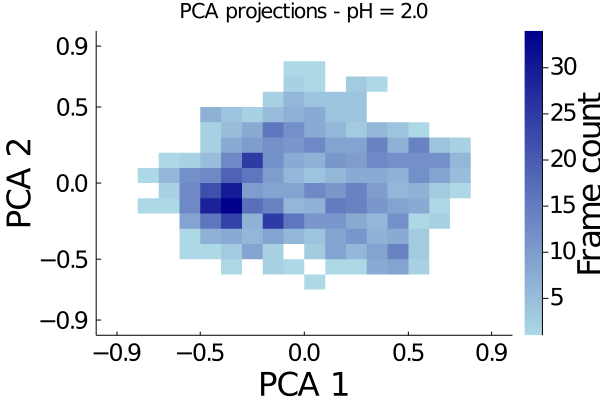

In [22]:
plt_prj_1_2_20_phs = histogram2d(smooth_prj_1_20_phs, smooth_prj_2_20_phs, 
        title = string("PCA projections - pH = ", 2.0),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

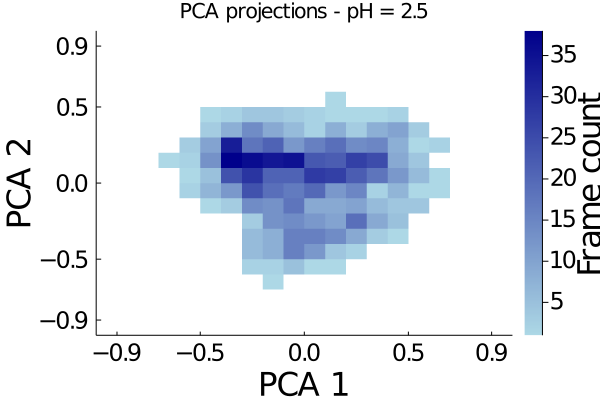

In [23]:
plt_prj_1_2_25_phs = histogram2d(smooth_prj_1_25_phs, smooth_prj_2_25_phs, 
        title = string("PCA projections - pH = ", 2.5),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

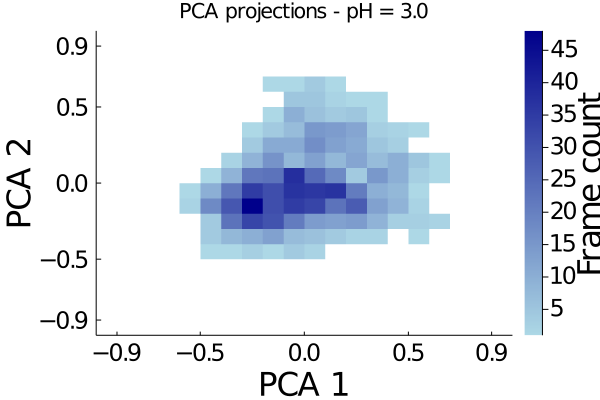

In [24]:
plt_prj_1_2_30_phs = histogram2d(smooth_prj_1_30_phs, smooth_prj_2_30_phs, 
        title = string("PCA projections - pH = ", 3.0),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

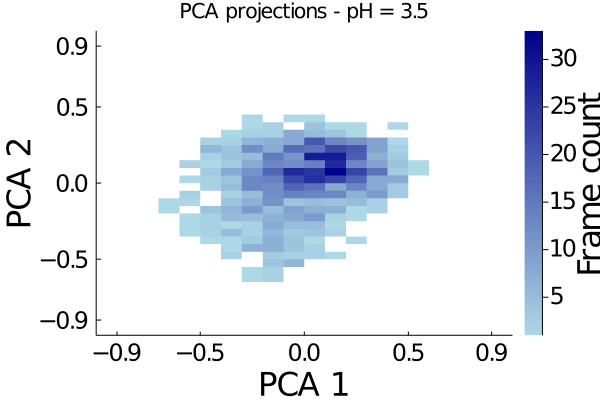

In [25]:
plt_prj_1_2_35_phs = histogram2d(smooth_prj_1_35_phs, smooth_prj_2_35_phs, 
        title = string("PCA projections - pH = ", 3.5),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

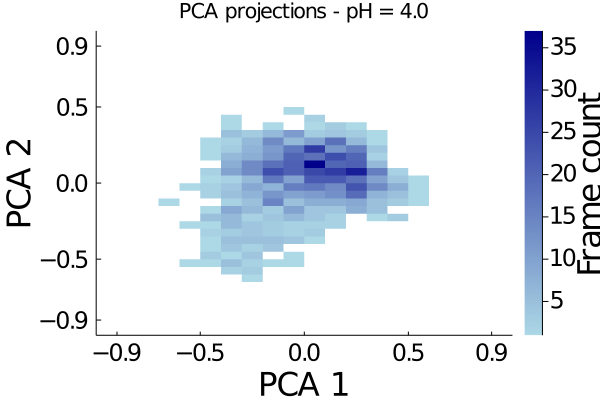

In [26]:
plt_prj_1_2_40_phs = histogram2d(smooth_prj_1_40_phs, smooth_prj_2_40_phs, 
        title = string("PCA projections - pH = ", 4.0),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

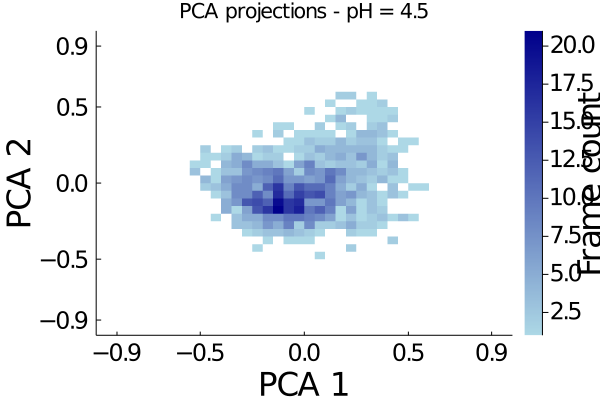

In [27]:
plt_prj_1_2_45_phs = histogram2d(smooth_prj_1_45_phs, smooth_prj_2_45_phs, 
        title = string("PCA projections - pH = ", 4.5),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

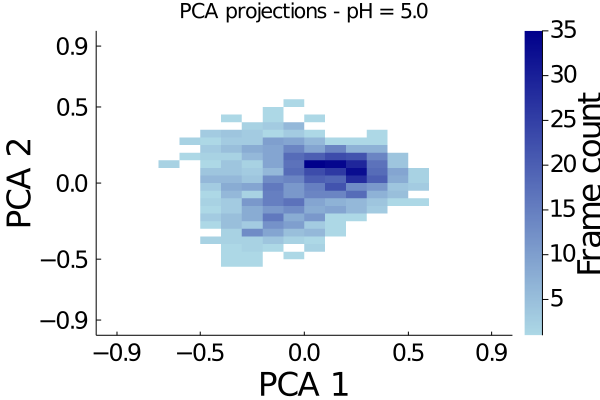

In [28]:
plt_prj_1_2_50_phs = histogram2d(smooth_prj_1_50_phs, smooth_prj_2_50_phs, 
        title = string("PCA projections - pH = ", 5.0),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

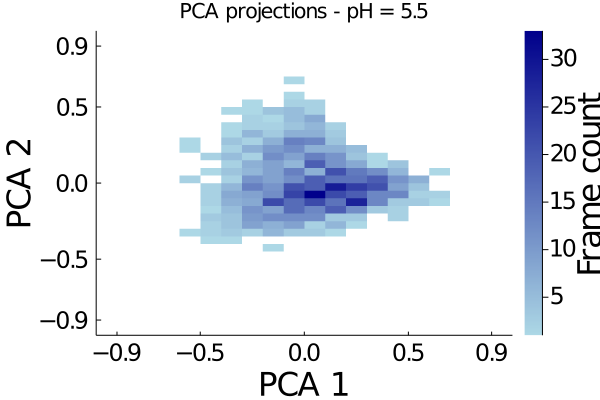

In [29]:
plt_prj_1_2_55_phs = histogram2d(smooth_prj_1_55_phs, smooth_prj_2_55_phs, 
        title = string("PCA projections - pH = ", 5.5),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

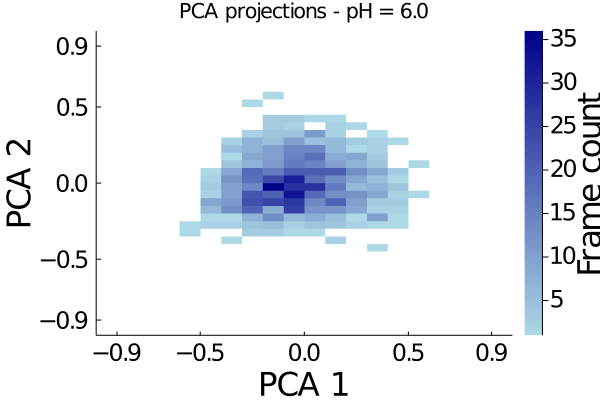

In [30]:
plt_prj_1_2_60_phs = histogram2d(smooth_prj_1_60_phs, smooth_prj_2_60_phs, 
        title = string("PCA projections - pH = ", 6.0),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

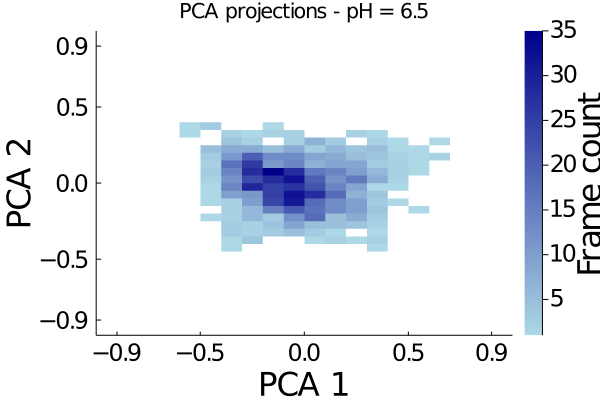

In [31]:
plt_prj_1_2_65_phs = histogram2d(smooth_prj_1_65_phs, smooth_prj_2_65_phs, 
        title = string("PCA projections - pH = ", 6.5),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

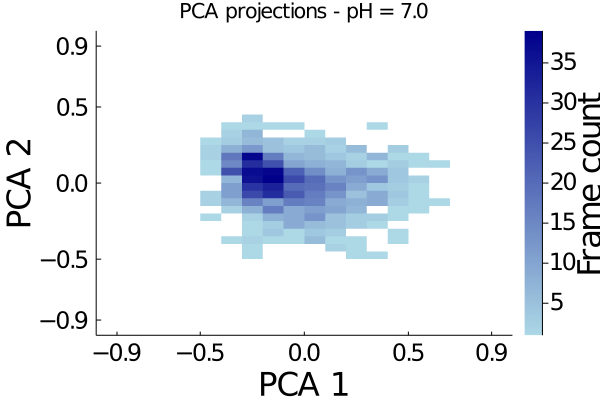

In [32]:
plt_prj_1_2_70_phs = histogram2d(smooth_prj_1_70_phs, smooth_prj_2_70_phs, 
        title = string("PCA projections - pH = ", 7.0),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

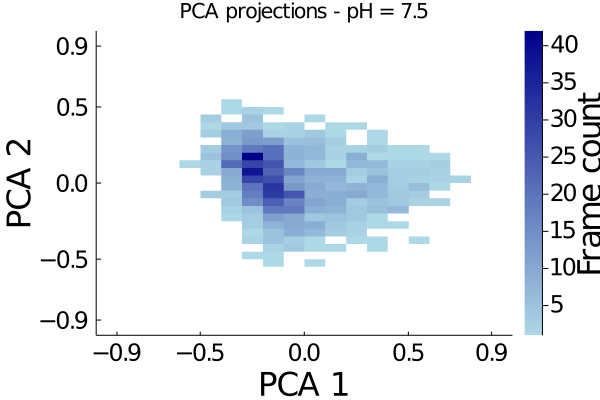

In [33]:
plt_prj_1_2_75_phs = histogram2d(smooth_prj_1_75_phs, smooth_prj_2_75_phs, 
        title = string("PCA projections - pH = ", 7.5),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

## PCA por idx

plt_prj_1_2_1_idx = histogram2d(smooth_prj_1_1_idx, smooth_prj_2_1_idx, 
        title = string("PCA projections - idx = ", 1),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

plt_prj_1_2_2_idx = histogram2d(smooth_prj_1_2_idx, smooth_prj_2_2_idx, 
        title = string("PCA projections - idx = ", 2),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

plt_prj_1_2_3_idx = histogram2d(smooth_prj_1_3_idx, smooth_prj_2_3_idx, 
        title = string("PCA projections - idx = ", 3),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

plt_prj_1_2_4_idx = histogram2d(smooth_prj_1_4_idx, smooth_prj_2_4_idx, 
        title = string("PCA projections - idx = ", 4),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

plt_prj_1_2_5_idx = histogram2d(smooth_prj_1_5_idx, smooth_prj_2_5_idx, 
        title = string("PCA projections - idx = ", 5),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

plt_prj_1_2_6_idx = histogram2d(smooth_prj_1_6_idx, smooth_prj_2_6_idx, 
        title = string("PCA projections - idx = ", 6),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

plt_prj_1_2_7_idx = histogram2d(smooth_prj_1_7_idx, smooth_prj_2_7_idx, 
        title = string("PCA projections - idx = ", 7),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

plt_prj_1_2_8_idx = histogram2d(smooth_prj_1_8_idx, smooth_prj_2_8_idx, 
        title = string("PCA projections - idx = ", 8),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

plt_prj_1_2_9_idx = histogram2d(smooth_prj_1_9_idx, smooth_prj_2_9_idx, 
        title = string("PCA projections - idx = ", 9),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

plt_prj_1_2_10_idx = histogram2d(smooth_prj_1_10_idx, smooth_prj_2_10_idx, 
        title = string("PCA projections - idx = ", 10),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

plt_prj_1_2_11_idx = histogram2d(smooth_prj_1_11_idx, smooth_prj_2_11_idx, 
        title = string("PCA projections - idx = ", 11),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)

plt_prj_1_2_12_idx = histogram2d(smooth_prj_1_12_idx, smooth_prj_2_12_idx, 
        title = string("PCA projections - idx = ", 12),
        xlims = (-1, 1), ylims = (-1, 1),
        xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
        yaxis = "PCA 2", xaxis = "PCA 1",
        colorbar_title = "Frame count",
        guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
        legendfont = font(16, "Arial"), #clims = (0, 15),
        nbins = 20, seriescolor = :blues, grid = false)